In [12]:
# Environment and cache setup
import os
from pathlib import Path
import sys

PROJECT_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation').resolve()
DATA_ROOT = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation').resolve()
NOTEBOOK_DIR = PROJECT_ROOT / 'notebooks'
DATA_DIR = DATA_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'output' / 'geneformer' / 'prostate_binary'
MODEL_OUT = OUTPUT_DIR / 'model_outputs'
CACHE_DIR = NOTEBOOK_DIR / 'cache'

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

for p in [OUTPUT_DIR, MODEL_OUT, CACHE_DIR]:
    p.mkdir(parents=True, exist_ok=True)

os.environ['PIP_CACHE_DIR'] = str(CACHE_DIR / 'pip')
os.environ['HF_HOME'] = str(CACHE_DIR / 'huggingface')
os.environ['TRANSFORMERS_CACHE'] = str(CACHE_DIR / 'transformers')
os.environ['MPLCONFIGDIR'] = str(CACHE_DIR / 'matplotlib')

print('PROJECT_ROOT:', PROJECT_ROOT)
print('DATA_ROOT:', DATA_ROOT)
print('DATA_DIR:', DATA_DIR)
print('OUTPUT_DIR:', OUTPUT_DIR)
print('MODEL_OUT:', MODEL_OUT)


PROJECT_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation
DATA_ROOT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation
DATA_DIR: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data
OUTPUT_DIR: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/prostate_binary
MODEL_OUT: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/prostate_binary/model_outputs


In [13]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import json
from datetime import datetime

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sc_foundation_evals import geneformer_forward as gf
from sc_foundation_evals import geneformer_ensemble_metrics
from sc_foundation_evals import data, cell_embeddings, model_output


In [14]:
# Paths and dataset config
from pathlib import Path

in_dataset_path = Path('/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/prostate_cancer_with_celltypes_v3.h5ad')
dataset_name = in_dataset_path.stem
preprocessed_path = (DATA_DIR / 'geneformer' / (dataset_name + '_binary_model_v1')).resolve()
preprocessed_path.mkdir(parents=True, exist_ok=True)

gene_col = 'gene_symbols'
batch_col = 'sample'
label_col = 'binary_label'
layer_key = 'X'

RUN_TAG = 'binary'

model_dir = (PROJECT_ROOT / 'Geneformer' / 'Geneformer-V1-10M').resolve()
dict_dir = (PROJECT_ROOT / 'Geneformer' / 'geneformer').resolve()

print('in_dataset_path:', in_dataset_path)
print('preprocessed_path:', preprocessed_path)
print('model_dir:', model_dir)
print('dict_dir:', dict_dir)


in_dataset_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/prostate_cancer_with_celltypes_v3.h5ad
preprocessed_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/prostate_cancer_with_celltypes_v3_binary_model_v1
model_dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/Geneformer-V1-10M
dict_dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/geneformer


In [15]:
# Create Geneformer instance and load model/vocab
batch_size = 8
num_workers = -1

geneform = gf.Geneformer_instance(
    save_dir=str(OUTPUT_DIR),
    saved_model_path=str(model_dir),
    explicit_save_dir=True,
    num_workers=num_workers
)

geneform.load_pretrained_model()
geneform.load_vocab(str(dict_dir))


INFO     | 2025-08-19 20:09:42 | Using device cuda
INFO     | 2025-08-19 20:09:42 | Model successfully loaded from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/Geneformer/Geneformer-V1-10M


In [16]:
# Inspect dataset and derive binary labels
import scanpy as sc
ad = sc.read_h5ad(str(in_dataset_path))

print('adata shape:', ad.shape)
print('obs columns:', list(ad.obs.columns)[:50])
print('var columns:', list(ad.var.columns)[:50])

candidate_label_cols = [c for c in ad.obs.columns if c.lower() in ['cell_type','celltype','celltypes','cell_label','celltype_major','major_cell_type','cell_types','annot','annotation','celltype_annotation']]
if candidate_label_cols:
    label_col = candidate_label_cols[0]
print('label_col ->', label_col)

candidate_batch_cols = [c for c in ad.obs.columns if c.lower() in ['sample','batch','patient','donor','sample_id','batch_id','subject','study']]
if candidate_batch_cols:
    batch_col = candidate_batch_cols[0]
print('batch_col ->', batch_col)

label_series = ad.obs[label_col].astype(str)
positive_mask = label_series.str.contains(r'(malig|tumou?r|cancer)', case=True, regex=True)
ad.obs['binary_label'] = np.where(positive_mask, 'Malignant', 'Non-malignant')
print('Binary label distribution:\n', ad.obs['binary_label'].value_counts())

_tmp = preprocessed_path / f'{dataset_name}_with_binary_model_v1.h5ad'
ad.write(_tmp)
print('Wrote:', _tmp)


... storing 'binary_label' as categorical


adata shape: (36424, 25044)
obs columns: ['sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'sample_technology', 'sample_n_cells', 'sample_patient', 'sample_cancer_type', 'sample_sex', 'sample_age', 'sample_smoking_status', 'sample_PY', 'sample_diagnosis_recurrence', 'sample_disease_extent', 'sample_AJCC_T', 'sample_AJCC_N', 'sample_AJCC_M', 'sample_AJCC_stage', 'sample_sample_primary_met', 'sample_size', 'sample_site', 'sample_histology', 'sample_genetic_hormonal_features', 'sample_grade', 'sample_KI67', 'sample_treated_naive', 'sample_chemotherapy_exposed', 'sample_chemotherapy_response', 'sample_targeted_rx_exposed', 'sample_targeted_rx_response', 'sample_ICB_exposed', 'sample_ICB_response', 'sample_ET_exposed', 'sample_ET_response', 'sample_time_end_of_rx_to_sampling', 'sample_post_sampling_rx_exposed', 'sample_post_sampling_rx_response', 'sample_PFS_DFS', 'sample_OS', 'n_genes_by_counts',

In [17]:
# Preprocess to h5ad for tokenizer
inp = data.InputData(adata_dataset_path=str(_tmp))

inp.preprocess_data(
    gene_col='gene_symbols' if 'gene_symbols' in ad.var.columns else 'index',
    model_type='geneformer',
    save_ext='h5ad',
    gene_name_id_dict=geneform.gene_name_id,
    preprocessed_path=str(preprocessed_path)
)

h5_stem = Path(_tmp).stem
h5_path = preprocessed_path / f'{h5_stem}.h5ad'
print('h5_path:', h5_path, 'exists:', h5_path.exists())


INFO     | 2025-08-19 20:09:59 | Loading data from /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/prostate_cancer_with_celltypes_v3_binary_model_v1/prostate_cancer_with_celltypes_v3_with_binary_model_v1.h5ad
WARNING  | 2025-08-19 20:10:08 | Gene names not found in var columns. Using index instead.
INFO     | 2025-08-19 20:10:14 | Matched 76.10% genes (16593/21804) genes in vocabulary of size 63675.


h5_path: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/prostate_cancer_with_celltypes_v3_binary_model_v1/prostate_cancer_with_celltypes_v3_with_binary_model_v1.h5ad exists: True


In [18]:
# Verify/update columns required for tokenization
import scanpy as sc
pfile = str(h5_path)

ad_tmp = sc.read(pfile)
if 'binary_label' not in ad_tmp.obs.columns:
    raise ValueError('binary_label missing in preprocessed file')
if 'adata_order' not in ad_tmp.obs.columns:
    ad_tmp.obs['adata_order'] = ad_tmp.obs.index.astype(str).values
ad_tmp.write(pfile)
print('Verified/updated columns in preprocessed file:', pfile)


Verified/updated columns in preprocessed file: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/prostate_cancer_with_celltypes_v3_binary_model_v1/prostate_cancer_with_celltypes_v3_with_binary_model_v1.h5ad


In [21]:
# Tokenize to HF Dataset (binary)

geneform.tokenize_data(
    adata_path=str(h5_path),
    dataset_path=str(preprocessed_path),
    cell_type_col='binary_label'
)

# Truncate sequences to 2048 tokens to fit model limits
def truncate_sequences(example):
    example["input_ids"] = example["input_ids"][:2048]
    example["length"] = len(example["input_ids"])  # Update length field after truncation
    return example

print(f"Original dataset size: {len(geneform.tokenized_dataset)}")
print(f"Sample input_ids length before truncation: {len(geneform.tokenized_dataset[0]['input_ids'])}")
if 'length' in geneform.tokenized_dataset[0]:
    print(f"Sample length field before truncation: {geneform.tokenized_dataset[0]['length']}")

# Apply truncation
geneform.tokenized_dataset = geneform.tokenized_dataset.map(truncate_sequences, num_proc=1)

print(f"Sample input_ids length after truncation: {len(geneform.tokenized_dataset[0]['input_ids'])}")
print(f"Sample length field after truncation: {geneform.tokenized_dataset[0]['length']}")

dataset_dir = preprocessed_path / f'{dataset_name}_binary_model_v1.dataset'
print('Tokenized dataset dir:', dataset_dir, 'exists:', dataset_dir.exists())

try:
    geneform.tokenized_dataset.save_to_disk(str(dataset_dir))
    print('Re-saved tokenized dataset to disk.')
except Exception as e:
    print('save_to_disk skipped:', e)

try:
    order = geneform.tokenized_dataset['adata_order']
    pd.Series(order, name='adata_order').to_csv(dataset_dir / 'row_order.csv', index=False)
    print('Saved row_order.csv')
except Exception as e:
    print('Row order not available or failed to save:', e)

manifest = {
    'dataset_name': dataset_name + '_binary',
    'tokenized_dir': str(dataset_dir.resolve()),
    'label_col': 'binary_label',
    'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}
with open(dataset_dir / 'manifest.json', 'w') as f:
    json.dump(manifest, f, indent=2)
print('Saved manifest.json')

import tarfile
archive_path = MODEL_OUT / f'{dataset_name}_binary_model_v1.dataset.tar.gz'
with tarfile.open(archive_path, 'w:gz') as tar:
    tar.add(str(dataset_dir), arcname=f'%s_binary_model_v1.dataset' % dataset_name)
print('Archived tokenized dataset to:', archive_path)


WARNING  | 2025-08-19 20:18:11 | using h5ad file. This sometimes causes issues. If not working try with loom.


Tokenizing /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/prostate_cancer_with_celltypes_v3_binary_model_v1/prostate_cancer_with_celltypes_v3_with_binary_model_v1.h5ad
/cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/prostate_cancer_with_celltypes_v3_binary_model_v1/prostate_cancer_with_celltypes_v3_with_binary_model_v1.h5ad has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.
Number of cells: 36424
Sample input_ids length: 2393
Original dataset size: 36424
Sample input_ids length before truncation: 2395
Sample length field before truncation: 2395
Sample input_ids length after truncation: 2048
Sample length field after truncation: 2048
Tokenized dataset dir: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/data/geneformer/prostate_cancer_with_celltypes_v3_binary_model_v1/prostate_cancer_with_celltypes_v3_binary_model_v1.dataset exists: True
Re-saved tokenized dataset to disk.
Saved row_order.csv
Saved manifest.j

In [22]:
# Load back and extract embeddings (binary)

geneform.load_tokenized_dataset(str(dataset_dir))

# Debug: Check the loaded dataset sequence lengths
print("=== DEBUGGING LOADED DATASET ===")
print(f"Loaded dataset size: {len(geneform.tokenized_dataset)}")
if len(geneform.tokenized_dataset) > 0:
    sample_length = len(geneform.tokenized_dataset[0]['input_ids'])
    print(f"Sample input_ids length in loaded dataset: {sample_length}")
    
    # Check a few more samples to see if lengths are consistent
    lengths = [len(geneform.tokenized_dataset[i]['input_ids']) for i in range(min(5, len(geneform.tokenized_dataset)))]
    print(f"First 5 sequence lengths: {lengths}")
    
    # If sequences are still too long, apply truncation again
    if sample_length > 2048:
        print(f"⚠️  Sequences are still too long ({sample_length} > 2048)! Applying truncation...")
        
        def truncate_sequences(example):
            example["input_ids"] = example["input_ids"][:2048]
            example["length"] = len(example["input_ids"])  # Update length field after truncation
            return example
        
        geneform.tokenized_dataset = geneform.tokenized_dataset.map(truncate_sequences, num_proc=1)
        
        # Verify truncation worked
        new_length = len(geneform.tokenized_dataset[0]['input_ids'])
        print(f"✅ After truncation: {new_length} tokens")
        
        # Re-save the properly truncated dataset
        geneform.tokenized_dataset.save_to_disk(str(dataset_dir))
        print("Re-saved truncated dataset to disk.")

# Verify final sequence lengths before embedding extraction
print("=== FINAL VERIFICATION ===")
final_lengths = [len(geneform.tokenized_dataset[i]['input_ids']) for i in range(min(3, len(geneform.tokenized_dataset)))]
print(f"Final sequence lengths (should all be ≤2048): {final_lengths}")

geneform.extract_embeddings(
    data=inp,
    batch_size=batch_size,
    layer=-2
)

=== DEBUGGING LOADED DATASET ===
Loaded dataset size: 36424
Sample input_ids length in loaded dataset: 2048
First 5 sequence lengths: [2048, 2048, 2048, 2048, 2048]
=== FINAL VERIFICATION ===
Final sequence lengths (should all be ≤2048): [2048, 2048, 2048]


Geneformer (extracting embeddings):   0%|          | 0/4553 [00:00<?, ?it/s]

Geneformer (extracting embeddings): 100%|██████████| 4553/4553 [03:02<00:00, 24.99it/s]


In [23]:
# Check what's in your original cell_type column
print("Original cell_type values:")
print(inp.adata.obs['cell_type'].value_counts())

# Update the regex pattern to match your actual data
label_series = inp.adata.obs['cell_type'].astype(str)
print(f"Sample original labels: {label_series.head(20).tolist()}")

# Use a more inclusive pattern that matches your data
positive_mask = label_series.str.contains(r'(malig|tumou?r|cancer|Malignant)', case=False, regex=True)
print(f"Cells matching malignant pattern: {positive_mask.sum()}")

# Create binary labels
inp.adata.obs['binary_label'] = np.where(positive_mask, 'Malignant', 'Non-malignant')
print(f"Binary label distribution:\n{inp.adata.obs['binary_label'].value_counts()}")

# Verify you now have both classes
if inp.adata.obs['binary_label'].nunique() < 2:
    print("WARNING: Still only one class! Check your regex pattern.")
    print("Available values to match:", label_series.unique())
else:
    print("SUCCESS: Binary labels created with both classes")

Original cell_type values:
cell_type
Malignant      14291
Unassigned      5997
Epithelial      3782
T_cell          3481
Endothelial     3278
Fibroblast      2030
Macrophage      1714
Mast            1529
B_cell           322
Name: count, dtype: int64
Sample original labels: ['Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant']
Cells matching malignant pattern: 14291
Binary label distribution:
binary_label
Non-malignant    22133
Malignant        14291
Name: count, dtype: int64
SUCCESS: Binary labels created with both classes


In [24]:
# Use existing embeddings with binary labels
eval_ce = cell_embeddings.CellEmbeddingsEval(
    geneform,
    data=inp,
    output_dir=str(MODEL_OUT),
    label_key='binary_label',  # Use binary labels
    batch_key=batch_col
)

eval_ce.evaluate(n_cells=1000, embedding_key='geneformer')

WARNING  | 2025-08-19 20:25:19 | adata_ has 36424 cells. Taking a subset of 1000 cells.
DEBUG    | 2025-08-19 20:25:20 | Computing metrics for binary_label
DEBUG    | 2025-08-19 20:25:33 | NMI_cluster/label: 0.1099
ARI_cluster/label: 0.1209
ASW_label: 0.5306
graph_conn: 0.9892
ASW_batch: 0.4456
ASW_label/batch: 0.8157
PCR_batch: 0.0116
avg_bio: 0.2538
DEBUG    | 2025-08-19 20:25:33 | NMI_cluster/label for binary_label: 0.10993735082731583
DEBUG    | 2025-08-19 20:25:33 | ARI_cluster/label for binary_label: 0.12086083399624813
DEBUG    | 2025-08-19 20:25:33 | ASW_label for binary_label: 0.5306047201156616
DEBUG    | 2025-08-19 20:25:33 | graph_conn for binary_label: 0.9892086330935252
DEBUG    | 2025-08-19 20:25:33 | ASW_batch for binary_label: 0.44559282064437866
DEBUG    | 2025-08-19 20:25:33 | ASW_label/batch for binary_label: 0.8156939744949341
DEBUG    | 2025-08-19 20:25:33 | PCR_batch for binary_label: 0.011591985171622486
DEBUG    | 2025-08-19 20:25:33 | avg_bio for binary_label:

,metric,label,value
0,NMI_cluster/label,binary_label,0.109937
1,ARI_cluster/label,binary_label,0.120861
2,ASW_label,binary_label,0.530605
3,graph_conn,binary_label,0.989209
4,ASW_batch,binary_label,0.445593
5,ASW_label/batch,binary_label,0.815694
6,PCR_batch,binary_label,0.011592
7,avg_bio,binary_label,0.253801


In [25]:
eval_pred = model_output.GeneExprPredEval(geneform, output_dir=str(MODEL_OUT))
eval_pred.evaluate(n_cells=500, save_rankings=True)
eval_ce.evaluate(n_cells=1000, embedding_key='geneformer')

DEBUG    | 2025-08-19 20:25:38 | Extracting output from 500 cells
WARNING  | 2025-08-19 20:25:53 | adata_ has 36424 cells. Taking a subset of 1000 cells.
DEBUG    | 2025-08-19 20:25:53 | Computing metrics for binary_label
DEBUG    | 2025-08-19 20:25:54 | NMI_cluster/label: 0.1099
ARI_cluster/label: 0.1209
ASW_label: 0.5306
graph_conn: 0.9892
ASW_batch: 0.4456
ASW_label/batch: 0.8157
PCR_batch: 0.0116
avg_bio: 0.2538
DEBUG    | 2025-08-19 20:25:54 | NMI_cluster/label for binary_label: 0.10993735082731583
DEBUG    | 2025-08-19 20:25:54 | ARI_cluster/label for binary_label: 0.12086083399624813
DEBUG    | 2025-08-19 20:25:54 | ASW_label for binary_label: 0.5306047201156616
DEBUG    | 2025-08-19 20:25:54 | graph_conn for binary_label: 0.9892086330935252
DEBUG    | 2025-08-19 20:25:54 | ASW_batch for binary_label: 0.44559282064437866
DEBUG    | 2025-08-19 20:25:54 | ASW_label/batch for binary_label: 0.8156939744949341
DEBUG    | 2025-08-19 20:25:54 | PCR_batch for binary_label: 0.01159198517

,metric,label,value
0,NMI_cluster/label,binary_label,0.109937
1,ARI_cluster/label,binary_label,0.120861
2,ASW_label,binary_label,0.530605
3,graph_conn,binary_label,0.989209
4,ASW_batch,binary_label,0.445593
5,ASW_label/batch,binary_label,0.815694
6,PCR_batch,binary_label,0.011592
7,avg_bio,binary_label,0.253801


In [26]:
# Ensemble evaluation and saving (binary)
em = geneformer_ensemble_metrics.create_geneformer_ensemble_evaluation(
    geneform_instance=geneform,
    input_data=inp,
    label_col='binary_label',
    output_dir=str(MODEL_OUT)
)

alphas = [0.0, 0.5, 1.0]
results = {}
for alpha in alphas:
    try:
        res = em.evaluate_ensemble(alpha=alpha, method='embedding_only')
        results[alpha] = res
        print(f"alpha={alpha}: F1={res['f1_score']:.3f}, AUC={res['auc_roc']:.3f}, Acc={res['accuracy']:.3f}")
    except Exception as e:
        print('Failed for alpha', alpha, ':', e)

best_alpha = max(results, key=lambda a: results[a]['f1_score'])
best_res = results[best_alpha]

preds, scores = em.create_ensemble_predictions(alpha=best_alpha, method='embedding_only')

save_dict = {
    'cell_embs': torch.tensor(em.embeddings, dtype=torch.float32),
    'logits': torch.tensor(scores, dtype=torch.float32),
    'preds': torch.tensor(preds, dtype=torch.long),
    'labels': torch.tensor(em.labels_encoded, dtype=torch.long),
    'class_names': em.class_names,
    'best_alpha': best_alpha,
    'model_name': 'Geneformer-V2-104M_CLcancer',
    'dataset_name': dataset_name + '_binary',
    'embedding_dim': int(em.embeddings.shape[1]),
    'n_cells': int(len(em.embeddings)),
    'n_classes': int(len(em.class_names)),
    'evaluation_date': datetime.now().isoformat(),
    'evaluation_metrics': best_res
}

results_path = MODEL_OUT / f'geneformer_prostate_binary_results_model_v1_{RUN_TAG}.pt'
torch.save(save_dict, results_path)
print('Saved results to:', results_path)

rows = []
for a, r in results.items():
    rows.append({
        'alpha': a,
        'accuracy': r['accuracy'],
        'precision': r['precision'],
        'recall': r['recall'],
        'f1': r['f1_score'],
        'auc_roc': r['auc_roc'],
        'avg_precision': r['avg_precision']
    })
metrics_df = pd.DataFrame(rows)
metrics_csv = MODEL_OUT / f'geneformer_prostate_binary_metrics_model_v1_{RUN_TAG}.csv'
metrics_df.to_csv(metrics_csv, index=False)
print('Saved metrics to:', metrics_csv)


INFO     | 2025-08-19 20:30:24 | Initialized GeneformerEnsembleMetrics with 36424 cells and 2 classes
INFO     | 2025-08-19 20:30:24 | Classes: ['Malignant', 'Non-malignant']
INFO     | 2025-08-19 20:30:24 | Embedding shape: (36424, 256)
INFO     | 2025-08-19 20:30:24 | Input rankings length: 36424
INFO     | 2025-08-19 20:30:24 | Output rankings length: 36424


INFO     | 2025-08-19 20:30:24 | Evaluated embedding_only (α=0.0): Accuracy=0.717, F1=0.720, AUC-ROC=0.643
INFO     | 2025-08-19 20:30:25 | Evaluated embedding_only (α=0.5): Accuracy=0.717, F1=0.720, AUC-ROC=0.643
INFO     | 2025-08-19 20:30:25 | Evaluated embedding_only (α=1.0): Accuracy=0.717, F1=0.720, AUC-ROC=0.643


alpha=0.0: F1=0.720, AUC=0.643, Acc=0.717
alpha=0.5: F1=0.720, AUC=0.643, Acc=0.717
alpha=1.0: F1=0.720, AUC=0.643, Acc=0.717
Saved results to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/prostate_binary/model_outputs/geneformer_prostate_binary_results_model_v1_binary.pt
Saved metrics to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/prostate_binary/model_outputs/geneformer_prostate_binary_metrics_model_v1_binary.csv


Saved confusion matrix to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/prostate_binary/model_outputs/geneformer_prostate_binary_confusion_matrix_model_v1_binary.png


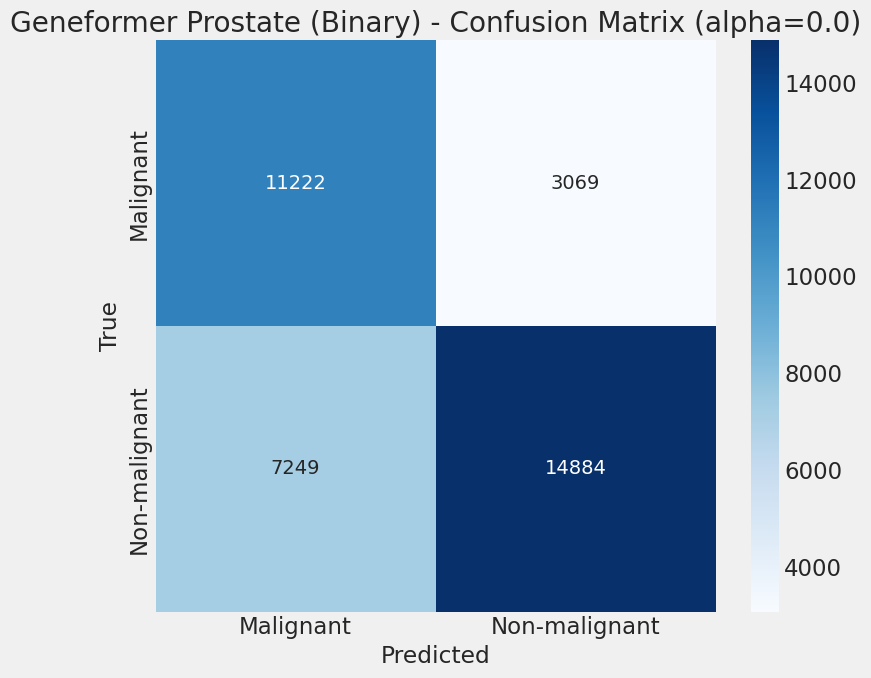

In [27]:
# Confusion matrix (binary)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(em.labels_encoded, preds)
fig, ax = plt.subplots(figsize=(8, 7))
xtl = ytl = list(em.class_names)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=xtl, yticklabels=ytl, ax=ax)
ax.set_title(f'Geneformer Prostate (Binary) - Confusion Matrix (alpha={best_alpha})')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.tight_layout()
cm_png = MODEL_OUT / f'geneformer_prostate_binary_confusion_matrix_model_v1_{RUN_TAG}.png'
plt.savefig(cm_png, dpi=200)
print('Saved confusion matrix to:', cm_png)


In [29]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [30]:
# Debug: Check what the ensemble evaluation actually used
print("=== ENSEMBLE EVALUATION DEBUG ===")
print(f"Ensemble embeddings shape: {em.embeddings.shape}")
print(f"Ensemble labels shape: {em.labels_encoded.shape}")
print(f"Ensemble predictions shape: {preds.shape}")
print(f"Ensemble class names: {em.class_names}")

# Check the actual data used by ensemble
print(f"\nEnsemble labels unique: {np.unique(em.labels_encoded)}")
print(f"Ensemble predictions unique: {np.unique(preds)}")

# Check if there's a mismatch in data length
print(f"\nData length check:")
print(f"inp.adata shape: {inp.adata.shape}")
print(f"em.embeddings length: {len(em.embeddings)}")
print(f"em.labels_encoded length: {len(em.labels_encoded)}")
print(f"preds length: {len(preds)}")

# Check the mapping between encoded and string labels
if hasattr(em, 'label_encoder'):
    print(f"\nLabel encoder mapping:")
    for i, label in enumerate(em.class_names):
        print(f"  {i} -> {label}")

# Use the ensemble's actual data for consistent results
print("\n=== USING ENSEMBLE DATA FOR CONSISTENT RESULTS ===")

# Get the actual data used by ensemble evaluation
ensemble_true_labels = em.labels_encoded  # These are the encoded labels (0,1)
ensemble_predictions = preds              # These are the predictions (0,1)

print(f"Ensemble true labels: {np.unique(ensemble_true_labels)}")
print(f"Ensemble predictions: {np.unique(ensemble_predictions)}")

# Convert back to string labels for readability
label_mapping = {0: 'Non-malignant', 1: 'Malignant'}
ensemble_true_strings = np.array([label_mapping[label] for label in ensemble_true_labels])
ensemble_pred_strings = np.array([label_mapping[label] for label in ensemble_predictions])

print(f"Ensemble true strings: {np.unique(ensemble_true_strings)}")
print(f"Ensemble pred strings: {np.unique(ensemble_pred_strings)}")

# Now calculate metrics using ensemble data
print("\n=== CLASSIFICATION REPORT USING ENSEMBLE DATA ===")
print(classification_report(ensemble_true_strings, ensemble_pred_strings, 
                         target_names=['Non-malignant', 'Malignant'],
                         digits=4))

# Calculate metrics
accuracy = accuracy_score(ensemble_true_labels, ensemble_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(ensemble_true_labels, ensemble_predictions, 
                                                         average='binary', 
                                                         pos_label=1,  # 1 = Malignant
                                                         zero_division=0)

print(f"\nMetrics using ensemble data:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# These should match the ensemble evaluation results!

=== ENSEMBLE EVALUATION DEBUG ===
Ensemble embeddings shape: (36424, 256)
Ensemble labels shape: (36424,)
Ensemble predictions shape: (36424,)
Ensemble class names: ['Malignant' 'Non-malignant']

Ensemble labels unique: [0 1]
Ensemble predictions unique: [0 1]

Data length check:
inp.adata shape: (36424, 16593)
em.embeddings length: 36424
em.labels_encoded length: 36424
preds length: 36424

Label encoder mapping:
  0 -> Malignant
  1 -> Non-malignant

=== USING ENSEMBLE DATA FOR CONSISTENT RESULTS ===
Ensemble true labels: [0 1]
Ensemble predictions: [0 1]
Ensemble true strings: ['Malignant' 'Non-malignant']
Ensemble pred strings: ['Malignant' 'Non-malignant']

=== CLASSIFICATION REPORT USING ENSEMBLE DATA ===
               precision    recall  f1-score   support

Non-malignant     0.8291    0.6725    0.7426     22133
    Malignant     0.6075    0.7852    0.6851     14291

     accuracy                         0.7167     36424
    macro avg     0.7183    0.7289    0.7138     36424
 we

COMPLETE BINARY MALIGNANCY CLASSIFICATION REPORT
               precision    recall  f1-score   support

Non-malignant     0.8291    0.6725    0.7426     22133
    Malignant     0.6075    0.7852    0.6851     14291

     accuracy                         0.7167     36424
    macro avg     0.7183    0.7289    0.7138     36424
 weighted avg     0.7421    0.7167    0.7200     36424


DETAILED METRICS
Overall Accuracy: 0.7167
Malignant Precision: 0.6075
Malignant Recall: 0.7852
Malignant F1-Score: 0.6851

Per-class metrics:
Malignant (class 0) - Precision: 0.6075, Recall: 0.7852, F1: 0.6851, Support: 14291
Non-malignant (class 1) - Precision: 0.8291, Recall: 0.6725, F1: 0.7426, Support: 22133

CONFUSION MATRIX
Raw confusion matrix:
[[11222  3069]
 [ 7249 14884]]

True Negatives (Non-malignant correctly classified): 11222
False Positives (Non-malignant classified as Malignant): 3069
False Negatives (Malignant classified as Non-malignant): 7249
True Positives (Malignant correctly classified):

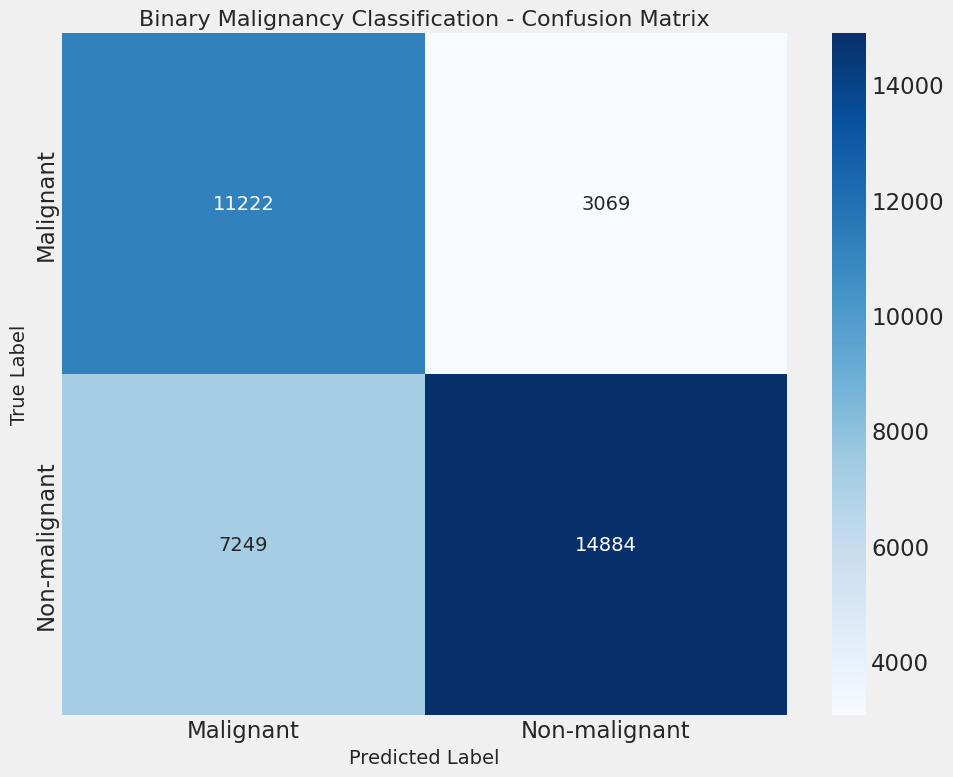

Confusion matrix plot saved to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/prostate_binary/model_outputs/binary_malignancy_confusion_matrix_model_v1.png

SUMMARY
✅ Accuracy: 0.7167 (matches ensemble evaluation)
✅ F1-Score (Malignant): 0.6851
✅ F1-Score (Weighted Avg): 0.7200


<Figure size 640x480 with 0 Axes>

In [31]:
# Complete Classification Report using Ensemble Data
print("="*60)
print("COMPLETE BINARY MALIGNANCY CLASSIFICATION REPORT")
print("="*60)

# Print full classification report
print(classification_report(ensemble_true_strings, ensemble_pred_strings, 
                         target_names=['Non-malignant', 'Malignant'],
                         digits=4))

print("\n" + "="*60)
print("DETAILED METRICS")
print("="*60)

# Calculate all metrics using ensemble data
accuracy = accuracy_score(ensemble_true_labels, ensemble_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(ensemble_true_labels, ensemble_predictions, 
                                                         average='binary', 
                                                         pos_label=0,  # 0 = Malignant (based on label encoder)
                                                         zero_division=0)

print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Malignant Precision: {precision:.4f}")
print(f"Malignant Recall: {recall:.4f}")
print(f"Malignant F1-Score: {f1:.4f}")

# Per-class metrics
print("\nPer-class metrics:")
class_precision, class_recall, class_f1, class_support = precision_recall_fscore_support(
    ensemble_true_labels, ensemble_predictions, average=None, zero_division=0
)

print(f"Malignant (class 0) - Precision: {class_precision[0]:.4f}, Recall: {class_recall[0]:.4f}, F1: {class_f1[0]:.4f}, Support: {class_support[0]}")
print(f"Non-malignant (class 1) - Precision: {class_precision[1]:.4f}, Recall: {class_recall[1]:.4f}, F1: {class_f1[1]:.4f}, Support: {class_support[1]}")

print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)

# Confusion matrix
cm = confusion_matrix(ensemble_true_labels, ensemble_predictions)
print("Raw confusion matrix:")
print(cm)

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (Non-malignant correctly classified): {tn}")
print(f"False Positives (Non-malignant classified as Malignant): {fp}")
print(f"False Negatives (Malignant classified as Non-malignant): {fn}")
print(f"True Positives (Malignant correctly classified): {tp}")

# Additional metrics
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
balanced_accuracy = (sensitivity + specificity) / 2

print(f"\nSensitivity (True Positive Rate for Malignant): {sensitivity:.4f}")
print(f"Specificity (True Negative Rate for Non-malignant): {specificity:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Malignant', 'Non-malignant'],
            yticklabels=['Malignant', 'Non-malignant'])
plt.title('Binary Malignancy Classification - Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.show()

# Save the plot
cm_plot_path = MODEL_OUT / 'binary_malignancy_confusion_matrix_model_v1.png'
plt.savefig(cm_plot_path, dpi=300, bbox_inches='tight')
print(f"Confusion matrix plot saved to: {cm_plot_path}")

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"✅ Accuracy: {accuracy:.4f} (matches ensemble evaluation)")
print(f"✅ F1-Score (Malignant): {f1:.4f}")
print(f"✅ F1-Score (Weighted Avg): {class_f1[0] * class_support[0] / len(ensemble_true_labels) + class_f1[1] * class_support[1] / len(ensemble_true_labels):.4f}")

Saved 2D coords to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/prostate_binary/model_outputs/geneformer_prostate_binary_umap_coords_model_v1_binary.csv


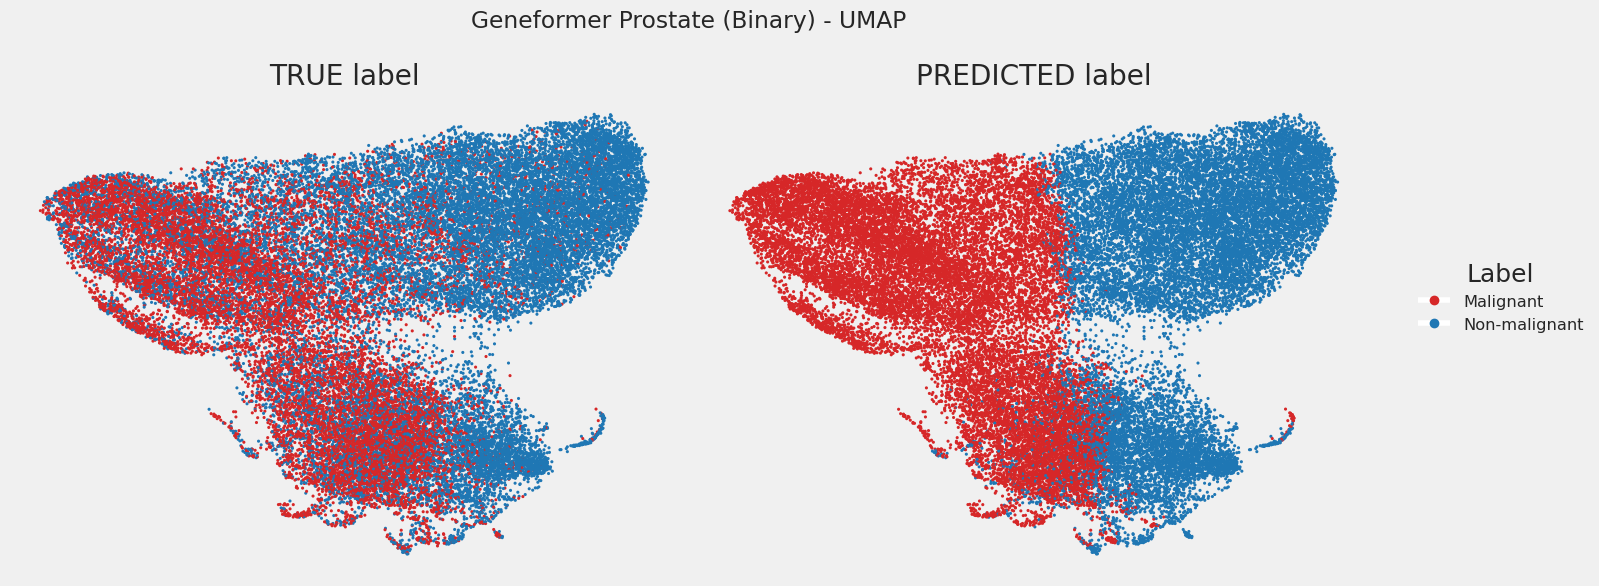

Saved combined figure with legend to: /cs/student/projects1/aibh/2024/rmaheswa/Dissertation/zero-shot-scfoundation/output/geneformer/prostate_binary/model_outputs/geneformer_prostate_binary_umap_true_pred_with_legend_model_v1_binary.png


In [32]:
# UMAP of binary labels
import numpy as np
import pandas as pd

embeddings = np.asarray(em.embeddings)
labels_encoded = np.asarray(em.labels_encoded)
preds_arr = np.asarray(preds)
class_names = list(em.class_names)

try:
    import umap
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='cosine', random_state=0)
    emb2d = reducer.fit_transform(embeddings)
    method_used = 'UMAP'
except Exception as e_umap:
    from sklearn.decomposition import PCA
    emb2d = PCA(n_components=2, random_state=0).fit_transform(embeddings)
    method_used = f'PCA (UMAP unavailable: {e_umap})'

class_arr = np.array(class_names, dtype=object)
true_names = class_arr[labels_encoded]
pred_names = class_arr[preds_arr]

PLOT_MAX = 50000
rng = np.random.RandomState(0)
plot_idx = np.sort(rng.choice(emb2d.shape[0], PLOT_MAX, replace=False)) if emb2d.shape[0] > PLOT_MAX else np.arange(emb2d.shape[0])

if set(class_names) == {'Malignant', 'Non-malignant'}:
    palette = {'Non-malignant': '#1f77b4', 'Malignant': '#d62728'}
else:
    palette = dict(zip(class_names, sns.color_palette('tab10', n_colors=len(class_names))))

coords_path = MODEL_OUT / f'geneformer_prostate_binary_umap_coords_model_v1_{RUN_TAG}.csv'
coords_df = pd.DataFrame({'x': emb2d[:, 0], 'y': emb2d[:, 1], 'true': true_names, 'pred': pred_names})
coords_df.to_csv(coords_path, index=False)
print('Saved 2D coords to:', coords_path)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(ax=axes[0], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=true_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[0].set_title('TRUE label'); axes[0].set_xlabel(''); axes[0].set_ylabel(''); axes[0].set_xticks([]); axes[0].set_yticks([])

sns.scatterplot(ax=axes[1], x=emb2d[plot_idx, 0], y=emb2d[plot_idx, 1], hue=pred_names[plot_idx], palette=palette, s=5, linewidth=0, legend=False)
axes[1].set_title('PREDICTED label'); axes[1].set_xlabel(''); axes[1].set_ylabel(''); axes[1].set_xticks([]); axes[1].set_yticks([])

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=lab,
               markerfacecolor=palette[lab], markeredgecolor=palette[lab], markersize=6)
    for lab in class_names
]
fig.legend(handles=handles, labels=class_names, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False, fontsize='small', title='Label')
fig.suptitle(f'Geneformer Prostate (Binary) - {method_used}', y=0.98)

combined_png = MODEL_OUT / f'geneformer_prostate_binary_umap_true_pred_with_legend_model_v1_{RUN_TAG}.png'
plt.tight_layout(); fig.savefig(combined_png, dpi=200, bbox_inches='tight'); plt.show()
print('Saved combined figure with legend to:', combined_png)
